# Predicting Machine Failure

## Introduction and Business Understanding

**Problem:** Machines on an automotive assembly lines are interdependent upon each other in order to produce a complete automobile. If a machine in this line fails, it would delay the completion of the next steps in the assembly process, or it may produce defective parts increasing waste. Given sensor data, is it possible to detect a machine failure?<br>
**Stakeholders:** Auto manufacturers<br>
**Solution:** Using supervised machine learning, we attempt to predict manufacturing machine failures. This gives lead time for maintenance or replacement of the faulty machine.

## Data Understanding

### Libraries

In [1]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from scipy.stats import randint, uniform
try:
    import dtreeviz
    %config InlineBackend.figure_format = 'retina' # Make visualizations look good
except:
    print('Please run "conda uninstall python-graphviz; conda uninstall graphviz; pip install dtreeviz" to install the tree visualization library')   
%matplotlib inline

# standard library
import time

# internal imports
from exploratory_analysis import util  # make_difference_features, make_multiplicative_features, calculate_and_display_accuracy
from exploratory_analysis import ga_hyperparameter_search as GaSearchCV  # genetic algorithm searches

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.2

## Data Preparation

### Preprocessing

In [2]:
data = pd.read_csv("machine failure.csv")

# combine failure types into one overall failure column
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)
# drop unneeded columns
data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

# add interaction features
subtraction_columns = util.make_difference_features(data.drop(columns=['Machine failure', 'Type']))
multiplication_columns = util.make_multiplicative_features(data.drop(columns=['Machine failure', 'Type']))
data = pd.concat([data, subtraction_columns, multiplication_columns], axis=1)

# perform different methods of transforming the quality
mapped_data = data.copy()
dummied_data = data.copy()

#### Mapping the quality type without one-hot encoding

In [3]:
# directly map the quality type without one-hot encoding
quality_map = {'L': 1, 'M': 2, 'H': 3}
mapped_data['Type'] = mapped_data['Type'].map(quality_map)

#### One-hot encoding the quality type

In [4]:
# one-hot encode the quality type
dummied_data = pd.get_dummies(dummied_data, columns=['Type',])

### Splitting

In [5]:
# split the mapped data
X_map = mapped_data.drop(columns='Machine failure')
y_map = mapped_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X_map, y_map, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_map)

# split the one-hot encoded data
X_dummy = dummied_data.drop(columns='Machine failure')
y_dummy = dummied_data['Machine failure']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_dummy)


### Standardizing

In [6]:
# standardize the mapped data
scaler = StandardScaler()
columns_to_scale = list(X_map_train.columns)
columns_to_scale.remove('Type')                # type is not numerical and more categorical

X_map_train[columns_to_scale] = scaler.fit_transform(X_map_train[columns_to_scale])
X_map_test[columns_to_scale] = scaler.transform(X_map_test[columns_to_scale])

# standardize the dummied data
X_dummy_train = scaler.fit_transform(X_dummy_train)
X_dummy_test = scaler.transform(X_dummy_test)

## Modeling

### Checking default, untuned models

We will test simpler models (logistic regression and decision tree) before moving to more advanced models (support vector machine, neural networks, random forest).

In [9]:
# naive model that guesses the most common class (0 or no machine failure)
accuracy_baseline = y_map_test.value_counts(normalize=True)[0]
accuracy_baseline

0.967

#### Logistic Regression - 0.970 accuracy, 0.59 precision, 0.24 recall

In [9]:
log_model = LogisticRegression(random_state=RANDOM_SEED)

log_model.fit(X_dummy_train, y_dummy_train)

y_pred_log = log_model.predict(X_dummy_test)

In [10]:
util.calculate_and_display_accuracy(log_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9738
Model Test accuracy:                                       0.9695
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.97375, 0.9695, 0.967, 0.967)

In [11]:
accuracy_log = accuracy_score(y_dummy_test, y_pred_log)

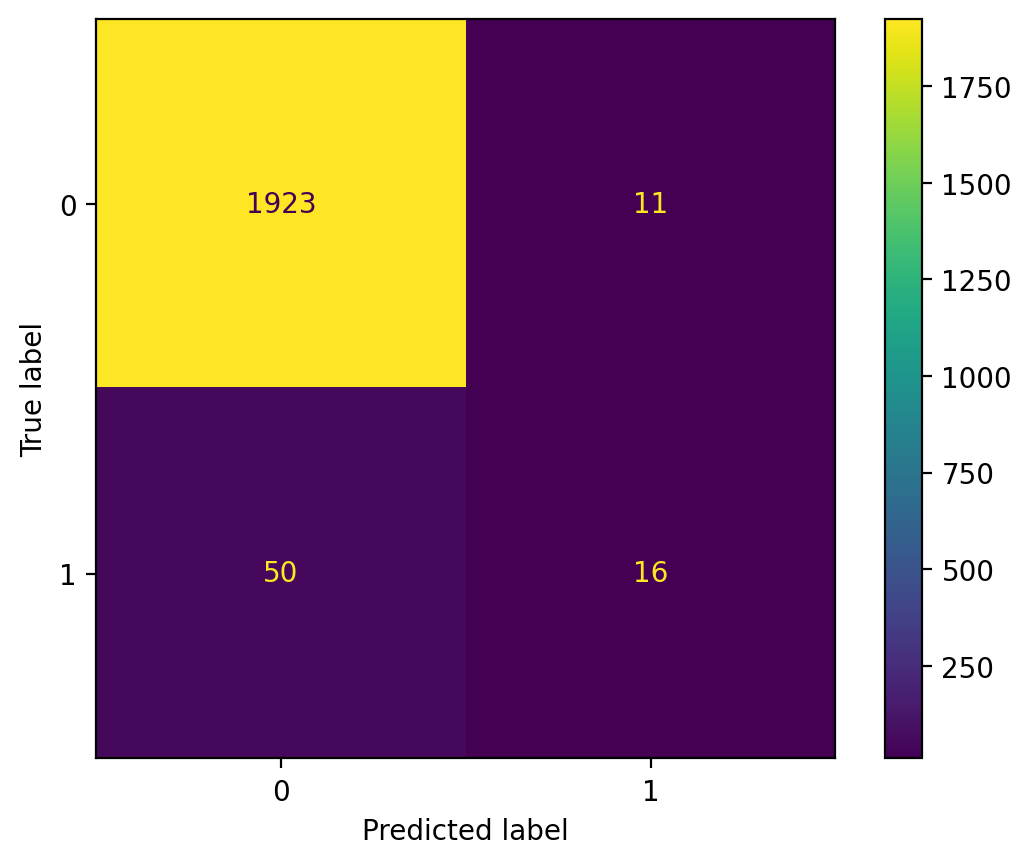

In [12]:
cm = confusion_matrix(y_map_test, y_pred_log, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()

In [13]:
print(classification_report(y_dummy_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1934
           1       0.59      0.24      0.34        66

    accuracy                           0.97      2000
   macro avg       0.78      0.62      0.66      2000
weighted avg       0.96      0.97      0.96      2000



#### Decision Tree - 0.986 accuracy, 0.75 precision, 0.86 recall

In [14]:
# Create the classifier, fit it on the training data and make predictions on the test set
tree_model = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model.fit(X_map_train, y_map_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [15]:
# Make predictions for test data
y_pred = tree_model.predict(X_map_test) 
y_pred_flt = np.array(y_pred).flatten()
y_test_flt = np.array(y_map_test).flatten()
y_train_flt = np.array(y_map_train).flatten()
y_pred_tree = y_pred

In [16]:
util.calculate_and_display_accuracy(tree_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.986
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(1.0, 0.986, 0.967, 0.967)

In [17]:
accuracy_tree = accuracy_score(y_dummy_test, y_pred_tree)

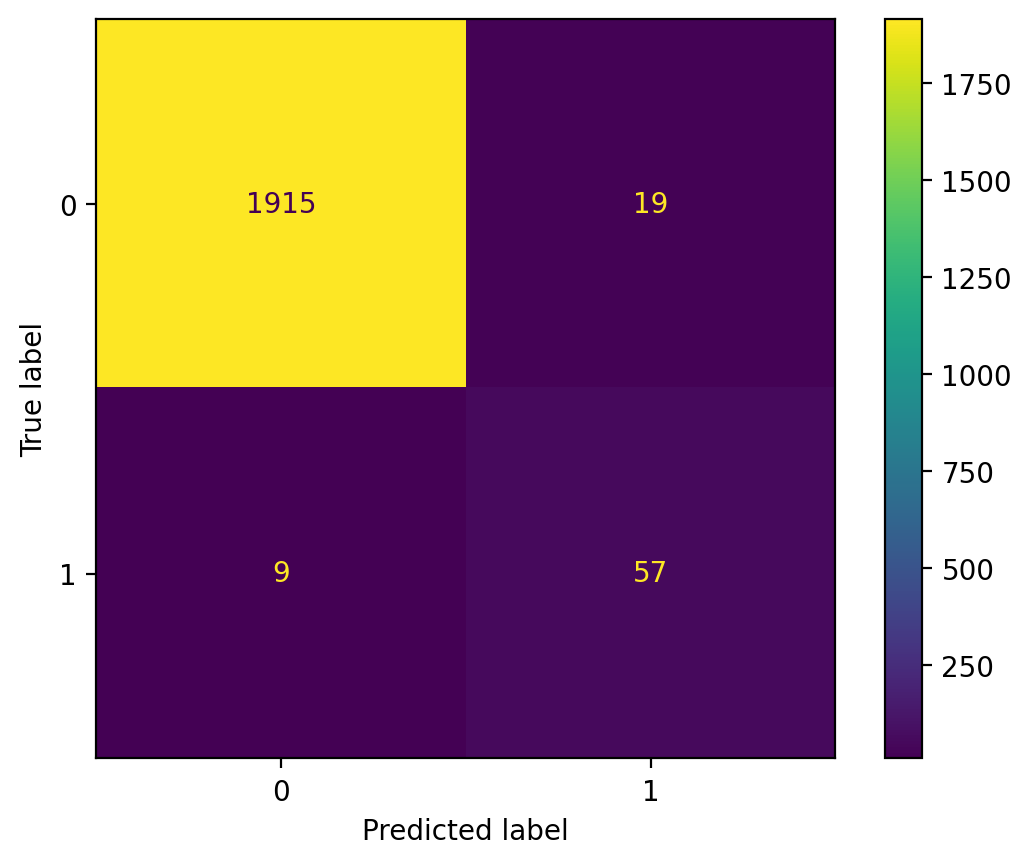

In [18]:
cm = confusion_matrix(y_map_test, y_pred_tree, labels=tree_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_model.classes_)
disp.plot()

In [19]:
print(classification_report(y_map_test, y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1934
           1       0.75      0.86      0.80        66

    accuracy                           0.99      2000
   macro avg       0.87      0.93      0.90      2000
weighted avg       0.99      0.99      0.99      2000



#### Support Vector Machine - 0.978 accuracy, 0.89 precision, 0.36 recall

In [20]:
svm_model = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model.fit(X_dummy_train, y_dummy_train)

# Predict
y_pred_svm = svm_model.predict(X_dummy_test)

In [21]:
util.calculate_and_display_accuracy(svm_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.981
Model Test accuracy:                                       0.9775
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.981, 0.9775, 0.967, 0.967)

In [22]:
accuracy_svm = accuracy_score(y_dummy_test, y_pred_svm)

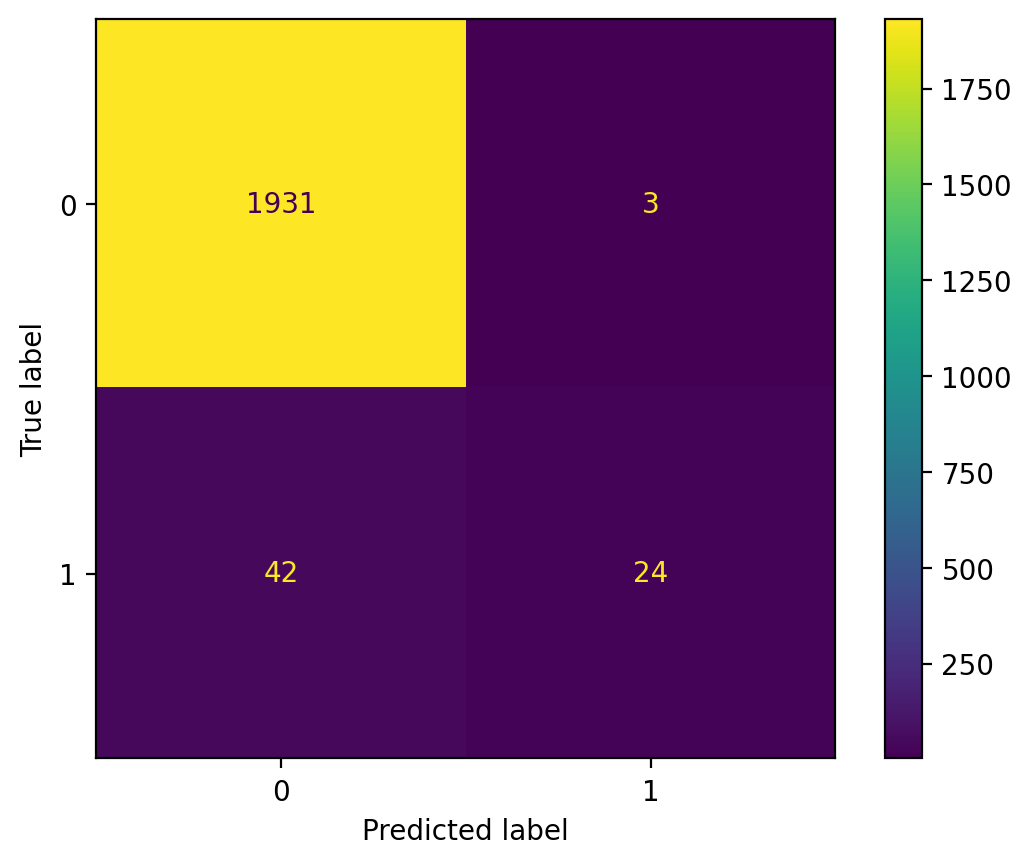

In [23]:
cm = confusion_matrix(y_dummy_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

In [24]:
print(classification_report(y_dummy_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1934
           1       0.89      0.36      0.52        66

    accuracy                           0.98      2000
   macro avg       0.93      0.68      0.75      2000
weighted avg       0.98      0.98      0.97      2000



#### Deep Neural Networks - 0.983 accuracy, 0.72 precision, 0.79 recall

In [25]:
# Create and train a neural network classifier
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model.fit(X_dummy_train, y_dummy_train)

# Make predictions on the test data
y_pred_nn = nn_model.predict(X_dummy_test)

In [26]:
util.calculate_and_display_accuracy(nn_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9955
Model Test accuracy:                                       0.983
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.9955, 0.983, 0.967, 0.967)

In [27]:
accuracy_nn = accuracy_score(y_dummy_test, y_pred_nn)

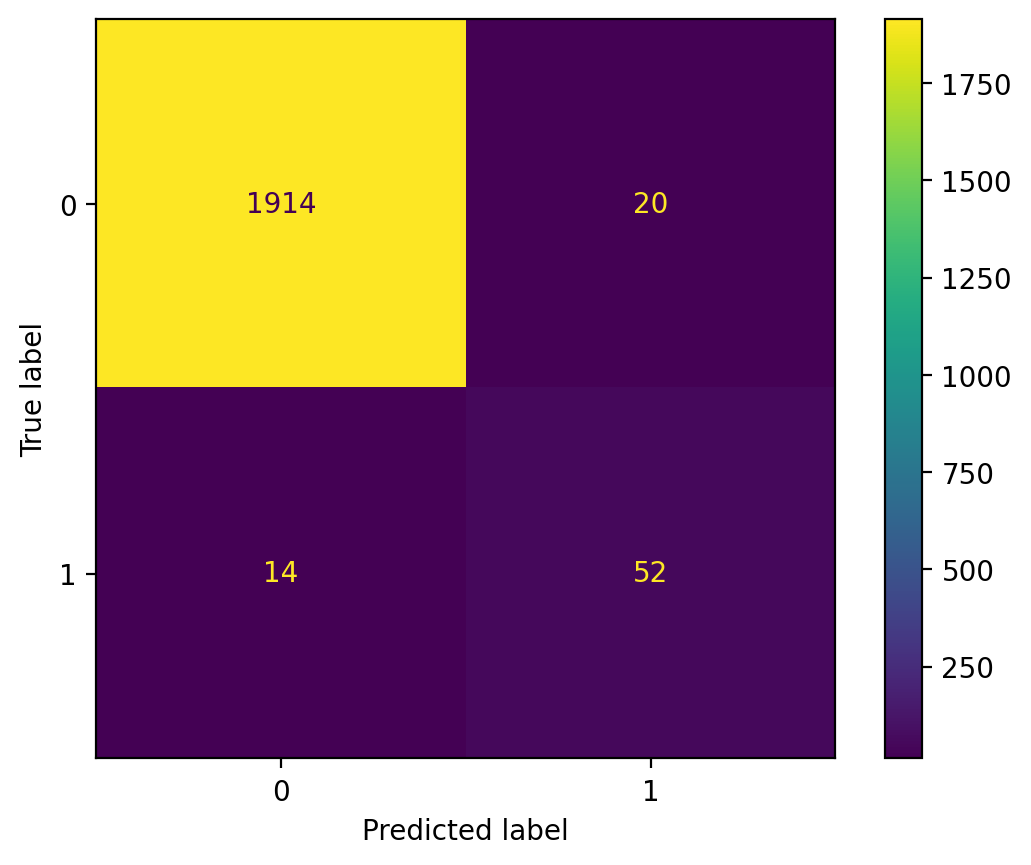

In [28]:
cm = confusion_matrix(y_dummy_test, y_pred_nn, labels=nn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn_model.classes_)
disp.plot()

In [29]:
print(classification_report(y_dummy_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1934
           1       0.72      0.79      0.75        66

    accuracy                           0.98      2000
   macro avg       0.86      0.89      0.87      2000
weighted avg       0.98      0.98      0.98      2000



#### Random Forest - 0.993 accuracy, 0.92 precision, 0.85 recall

In [30]:
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model.fit(X_map_train, y_map_train)
y_pred_rf = rf_model.predict(X_map_test)

In [31]:
util.calculate_and_display_accuracy(rf_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9925
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(1.0, 0.9925, 0.967, 0.967)

In [32]:
accuracy_rf = accuracy_score(y_dummy_test, y_pred_rf)

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

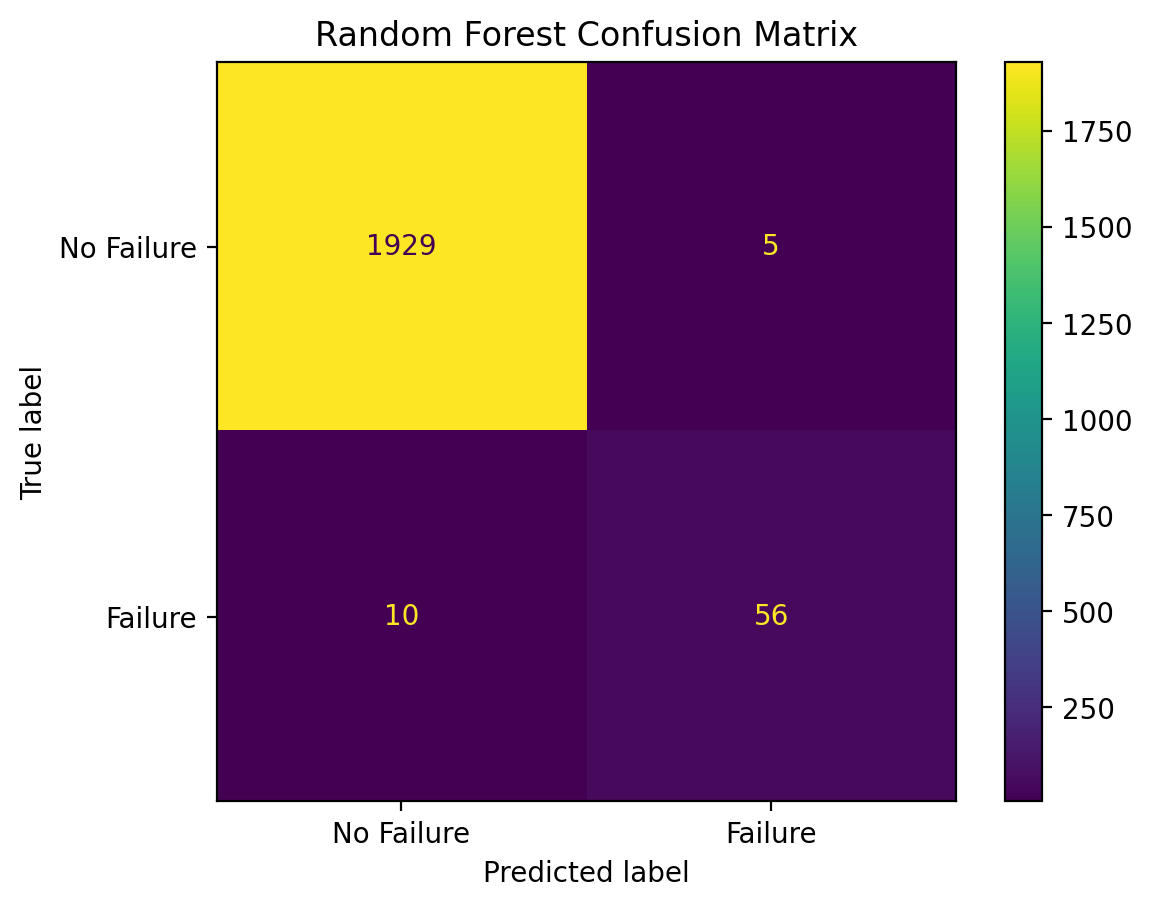

In [33]:
cm = confusion_matrix(y_map_test, y_pred_rf, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot()
disp.ax_.set_title("Random Forest Confusion Matrix")
#plt.savefig('random_forest_test_confusion_matrix.svg', format='svg', bbox_inches='tight')

In [34]:
print(classification_report(y_map_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1934
           1       0.92      0.85      0.88        66

    accuracy                           0.99      2000
   macro avg       0.96      0.92      0.94      2000
weighted avg       0.99      0.99      0.99      2000



### Addressing Class Imbalance

#### SMOTE

SMOTE addresses class imbalance by oversampling the minority class.

In [28]:
smote_resampler = SMOTE(random_state=RANDOM_SEED)
X_map_train_smote, y_map_train_smote = smote_resampler.fit_resample(X_map_train, y_map_train)
X_dummy_train_smote, y_dummy_train_smote = smote_resampler.fit_resample(X_dummy_train, y_dummy_train)

##### Logistic regression accuracy decreased from 0.970 to 0.865

In [29]:
log_model_test = LogisticRegression(random_state=RANDOM_SEED)
log_model_smote = LogisticRegression(random_state=RANDOM_SEED)

log_model_test.fit(X_dummy_train, y_dummy_train)
log_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(log_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(log_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.970
---Model on SMOTE Data---
Accuracy on holdout: 0.865


C:\Users\hzuo\AppData\Local\anaconda3\envs\ai_stuff\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


##### Decision tree accuracy decreased from 0.986 to 0.974

In [30]:
tree_model_test = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)
tree_model_smote = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model_test.fit(X_map_train, y_map_train)
tree_model_smote.fit(X_map_train_smote, y_map_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_smote, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.986
---Model on SMOTE Data---
Accuracy on holdout: 0.974


##### Support vector machine accuracy decreased from 0.978 to 0.918

In [114]:
svm_model_test = SVC(random_state=RANDOM_SEED)
svm_model_smote = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model_test.fit(X_dummy_train, y_dummy_train)
svm_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.978
---Model on SMOTE Data---
Accuracy on holdout: 0.918


##### Deep neural networks accuracy decreased from 0.983 to 0.966

In [115]:
# Create and train a neural network classifier
nn_model_test = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model_smote = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)

nn_model_test.fit(X_dummy_train, y_dummy_train)
nn_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.983
---Model on SMOTE Data---
Accuracy on holdout: 0.966


##### Random forest accuracy decreased from 0.993 to 0.971

In [116]:
rf_model_test = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model_smote = RandomForestClassifier(random_state=RANDOM_SEED)

rf_model_test.fit(X_map_train, y_map_train)
rf_model_smote.fit(X_map_train_smote, y_map_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_smote, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.993
---Model on SMOTE Data---
Accuracy on holdout: 0.971


##### Models that trained on SMOTE rebalanced data performed *worse* than the models trained on the raw, imbalanced data. This decrease is significant, often several percent, and makes many of these models *worse* than the baseline model's accuracy of 0.967.

#### TOMEK links

TOMEK links address class imbalance indirectly by removing points on the boundary between the two classes.

In [7]:
tomek_resampler = TomekLinks()
X_map_train_tomek, y_map_train_tomek = tomek_resampler.fit_resample(X_map_train, y_map_train)
X_dummy_train_tomek, y_dummy_train_tomek = tomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

##### Logistic regression accuracy stayed the same at 0.970

In [120]:
log_model_test = LogisticRegression(random_state=RANDOM_SEED)
log_model_tomek = LogisticRegression(random_state=RANDOM_SEED)

log_model_test.fit(X_dummy_train, y_dummy_train)
log_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(log_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(log_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.970
---Model on TOMEK Data---
Accuracy on holdout: 0.970


##### Decision tree accuracy increased from 0.986 to 0.987

In [121]:
tree_model_test = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)
tree_model_tomek = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model_test.fit(X_map_train, y_map_train)
tree_model_tomek.fit(X_map_train_tomek, y_map_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_tomek, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.986
---Model on TOMEK Data---
Accuracy on holdout: 0.987


##### Support vector machine accuracy decreased from 0.978 to 0.977

In [122]:
svm_model_test = SVC(random_state=RANDOM_SEED)
svm_model_tomek = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model_test.fit(X_dummy_train, y_dummy_train)
svm_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.978
---Model on TOMEK Data---
Accuracy on holdout: 0.977


##### Deep neural networks accuracy decreased from 0.983 to 0.981

In [123]:
# Create and train a neural network classifier
nn_model_test = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model_tomek = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)

nn_model_test.fit(X_dummy_train, y_dummy_train)
nn_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.983
---Model on TOMEK Data---
Accuracy on holdout: 0.981


##### Random forest accuracy decreased from 0.993 to 0.992

In [124]:
rf_model_test = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model_tomek = RandomForestClassifier(random_state=RANDOM_SEED)

rf_model_test.fit(X_map_train, y_map_train)
rf_model_tomek.fit(X_map_train_tomek, y_map_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_tomek, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.993
---Model on TOMEK Data---
Accuracy on holdout: 0.992


##### Removing TOMEK links does not substantially boost or degrade accuracy. Therefore, we will leave it out of the subsequent tuning step to maintain a level playing field with the untuned models. If we change both the data and the parameters, then we won't be certain which caused the increase or decrease in performance.

#### Logistic regression accuracy decreased from 0.970 to 0.865

In [29]:
log_model_test = LogisticRegression(random_state=RANDOM_SEED)
log_model_smote = LogisticRegression(random_state=RANDOM_SEED)

log_model_test.fit(X_dummy_train, y_dummy_train)
log_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(log_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(log_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.970
---Model on SMOTE Data---
Accuracy on holdout: 0.865


C:\Users\hzuo\AppData\Local\anaconda3\envs\ai_stuff\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### Decision tree accuracy decreased from 0.986 to 0.974

In [30]:
tree_model_test = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)
tree_model_smote = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model_test.fit(X_map_train, y_map_train)
tree_model_smote.fit(X_map_train_smote, y_map_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_smote, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.986
---Model on SMOTE Data---
Accuracy on holdout: 0.974


#### Support vector machine accuracy decreased from 0.978 to 0.918

In [114]:
svm_model_test = SVC(random_state=RANDOM_SEED)
svm_model_smote = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model_test.fit(X_dummy_train, y_dummy_train)
svm_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.978
---Model on SMOTE Data---
Accuracy on holdout: 0.918


#### Deep neural networks accuracy decreased from 0.983 to 0.966

In [115]:
# Create and train a neural network classifier
nn_model_test = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model_smote = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)

nn_model_test.fit(X_dummy_train, y_dummy_train)
nn_model_smote.fit(X_dummy_train_smote, y_dummy_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_smote, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.983
---Model on SMOTE Data---
Accuracy on holdout: 0.966


#### Random forest accuracy decreased from 0.993 to 0.971

In [116]:
rf_model_test = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model_smote = RandomForestClassifier(random_state=RANDOM_SEED)

rf_model_test.fit(X_map_train, y_map_train)
rf_model_smote.fit(X_map_train_smote, y_map_train_smote)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on SMOTE Data---')
train_acc, smote_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_smote, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {smote_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.993
---Model on SMOTE Data---
Accuracy on holdout: 0.971


#### Models that trained on SMOTE rebalanced data performed *worse* than the models trained on the raw, imbalanced data. This decrease is significant, often several percent, and makes many of these models *worse* than the baseline model's accuracy of 0.967.

**TOMEK links address class imbalance indirectly by removing points on the boundary between the two classes.**

In [8]:
tomek_resampler = TomekLinks()
X_map_train_tomek, y_map_train_tomek = tomek_resampler.fit_resample(X_map_train, y_map_train)
X_dummy_train_tomek, y_dummy_train_tomek = tomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

#### Logistic regression accuracy stayed the same at 0.970

In [120]:
log_model_test = LogisticRegression(random_state=RANDOM_SEED)
log_model_tomek = LogisticRegression(random_state=RANDOM_SEED)

log_model_test.fit(X_dummy_train, y_dummy_train)
log_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(log_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(log_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.970
---Model on TOMEK Data---
Accuracy on holdout: 0.970


#### Decision tree accuracy increased from 0.986 to 0.987

In [121]:
tree_model_test = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)
tree_model_tomek = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model_test.fit(X_map_train, y_map_train)
tree_model_tomek.fit(X_map_train_tomek, y_map_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(tree_model_tomek, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.986
---Model on TOMEK Data---
Accuracy on holdout: 0.987


#### Support vector machine accuracy decreased from 0.978 to 0.977

In [122]:
svm_model_test = SVC(random_state=RANDOM_SEED)
svm_model_tomek = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model_test.fit(X_dummy_train, y_dummy_train)
svm_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(svm_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.978
---Model on TOMEK Data---
Accuracy on holdout: 0.977


#### Deep neural networks accuracy decreased from 0.983 to 0.981

In [123]:
# Create and train a neural network classifier
nn_model_test = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model_tomek = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)

nn_model_test.fit(X_dummy_train, y_dummy_train)
nn_model_tomek.fit(X_dummy_train_tomek, y_dummy_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_test, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(nn_model_tomek, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.983
---Model on TOMEK Data---
Accuracy on holdout: 0.981


#### Random forest accuracy decreased from 0.993 to 0.992

In [124]:
rf_model_test = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model_tomek = RandomForestClassifier(random_state=RANDOM_SEED)

rf_model_test.fit(X_map_train, y_map_train)
rf_model_tomek.fit(X_map_train_tomek, y_map_train_tomek)

print('---Model on Raw, Imbalanced Data---')
train_acc, raw_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_test, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {raw_test_acc:.3f}')
print('---Model on TOMEK Data---')
train_acc, tomek_test_acc, *_ = util.calculate_and_display_accuracy(rf_model_tomek, X_map_train, y_map_train, X_map_test, y_map_test, verbose=False)
print(f'Accuracy on holdout: {tomek_test_acc:.3f}')

---Model on Raw, Imbalanced Data---
Accuracy on holdout: 0.993
---Model on TOMEK Data---
Accuracy on holdout: 0.992


#### From these tests, we see that removing TOMEK links does not substantially boost or degrade accuracy.

### Tuning Hyperparameters on Decision Tree, Deep Neural Networks, and Random Forest

#### Decision tree

##### Random search tuning increased accuracy from 0.986 to 0.990

In [30]:
# Based on code from 'Hyperparameter Optimization With Random Search and Grid Search'
# Author: Jason Brownlee
# Link: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

# define model
rsearch_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

# define parameter search space
parameters = {'max_depth': randint(1, 26),
              'min_samples_split': uniform(0.01, 0.99),
              'min_samples_leaf': randint(1, 31),
              'max_features': uniform(0.01, 0.99),
              'min_impurity_decrease': uniform(0.001, 0.03)}

start_time = time.perf_counter()
search = RandomizedSearchCV(rsearch_tree, parameters, n_iter=500, scoring='accuracy', n_jobs=-1,
                            cv=3, random_state=RANDOM_SEED)

result = search.fit(X_map_train, y_map_train)

print(f'Elapsed seconds: {time.perf_counter() - start_time}')
params = ', '.join([f"{parameter}={value}" for parameter, value in result.best_params_.items()])
print(f'Params: {params}')
print(f'Accuracy {result.best_score_}')

Elapsed seconds: 6.9829625000002125
Params: max_depth=21, max_features=0.9635903140462052, min_impurity_decrease=0.0013646342406944904, min_samples_leaf=13, min_samples_split=0.05272831283107035
Accuracy 0.9926247966191023


In [183]:
rsearch_tree = DecisionTreeClassifier(random_state=RANDOM_SEED,
                                      max_depth=21,
                                      max_features=0.9635903140462052,
                                      min_impurity_decrease=0.0013646342406944904,
                                      min_samples_leaf=13,
                                      min_samples_split=0.05272831283107035)
rsearch_tree.fit(X_map_train, y_map_train)

DecisionTreeClassifier(max_depth=21, max_features=0.9635903140462052,
                       min_impurity_decrease=0.0013646342406944904,
                       min_samples_leaf=13,
                       min_samples_split=0.05272831283107035, random_state=42)

In [184]:
acc_training, accuracy_rs_tree, *_ = util.calculate_and_display_accuracy(rsearch_tree, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9929
Model Test accuracy:                                       0.9895
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


##### Genetic algorithm tuning increased accuracy from 0.986 to 0.990

In [8]:
GaSearchCV.search_parameters('decision tree', MAX_GENERATIONS=7)

Resetting to default decision tree bounds because passed bounds do not match decision tree parameters
gen	nevals	max     	avg     
0  	20    	0.981875	0.969063
1  	14    	0.9835  	0.973131
2  	12    	0.983625	0.976944
3  	13    	0.983625	0.980656
4  	13    	0.992125	0.984306
5  	12    	0.992125	0.9857  
6  	15    	0.992625	0.987369
7  	15    	0.992625	0.990012
Total evaluated estimators: 114
Elapsed seconds: 183.6
---Best Solution---
params:  max_depth=14, min_samples_split=0.03, min_samples_leaf=7, max_features=0.75, min_impurity_decrease=0.0011
accuracy: 0.993


In [65]:
ga_tree = DecisionTreeClassifier(max_depth=14, min_samples_split=0.03, min_samples_leaf=7,
                                 max_features=0.75, min_impurity_decrease=0.0011,
                                 random_state=RANDOM_SEED)
ga_tree.fit(X_map_train, y_map_train)

DecisionTreeClassifier(max_depth=14, max_features=0.75,
                       min_impurity_decrease=0.0011, min_samples_leaf=7,
                       min_samples_split=0.03, random_state=42)

In [185]:
acc_training, accuracy_ga_tree, *_ = util.calculate_and_display_accuracy(ga_tree, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9928
Model Test accuracy:                                       0.9895
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


#### Deep neural networks

##### Random search tuning increased accuracy from 0.983 to 0.985

In [25]:
# Based on code from 'Hyperparameter Optimization With Random Search and Grid Search'
# Author: Jason Brownlee
# Link: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

# define model
rsearch_nn = MLPClassifier(random_state=RANDOM_SEED, solver='lbfgs', max_iter=300)

# define parameter search space
parameters = {'hidden_layer_sizes': [(randint.rvs(3,16,1),randint.rvs(0,11,1),), 
                                     (randint.rvs(0,11,1),)],
              'activation': ['tanh', 'relu', 'logistic'],
              'alpha': uniform(0.0001, 2)
             }

start_time = time.perf_counter()
search = RandomizedSearchCV(rsearch_nn, parameters, n_iter=500, scoring='accuracy', n_jobs=-1,
                            cv=3, random_state=RANDOM_SEED)

result = search.fit(X_dummy_train, y_dummy_train)

print(f'Elapsed seconds: {time.perf_counter() - start_time}')
params = ', '.join([f"{parameter}={value}" for parameter, value in result.best_params_.items()])
print(f'Params: {params}')
print(f'Accuracy {result.best_score_}')

Elapsed seconds: 278.16117849999955
Params: activation=tanh, alpha=0.1632883608004807, hidden_layer_sizes=(5, 8)
Accuracy 0.9873749370976039


C:\Users\hzuo\AppData\Local\anaconda3\envs\ai_stuff\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [67]:
rsearch_nn = MLPClassifier(random_state=RANDOM_SEED, solver='lbfgs', max_iter=300,
                           activation='tanh', alpha=0.1632883608004807, hidden_layer_sizes=(5, 8)
                          )
rsearch_nn.fit(X_dummy_train, y_dummy_train)

C:\Users\hzuo\AppData\Local\anaconda3\envs\ai_stuff\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', alpha=0.1632883608004807,
              hidden_layer_sizes=(5, 8), max_iter=300, random_state=42,
              solver='lbfgs')

In [189]:
acc_training, accuracy_rs_nn, *_ = util.calculate_and_display_accuracy(rsearch_nn, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9915
Model Test accuracy:                                       0.9845
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


##### Genetic algorithm tuning increased accuracy from 0.983 to 0.990

In [8]:
GaSearchCV.search_parameters('neural networks', POPULATION_SIZE=30, MAX_GENERATIONS=10,
                             HALL_OF_FAME_SIZE=2, P_MUTATION=0.7,
                             RANDOM_SEED=RANDOM_SEED)

Resetting to default MLP bounds because passed bounds do not match MLP parameters
gen	nevals	max     	avg     
0  	30    	0.985875	0.980225
1  	28    	0.985875	0.982271
2  	28    	0.985875	0.98345 
3  	26    	0.9865  	0.984337
4  	26    	0.987875	0.984766
5  	27    	0.988125	0.985366
6  	28    	0.988375	0.985887
7  	27    	0.988375	0.986233
8  	28    	0.988375	0.985867
9  	26    	0.988375	0.986292
10 	28    	0.988375	0.986771
Total evaluated estimators: 302
Elapsed seconds: 391.6
---Best Solution---
params:  hidden_layer_sizes=(5, 5), activation='tanh', solver='lbfgs', alpha=1.2959647006636335, max_iter=300
accuracy: 0.988


In [69]:
ga_nn = MLPClassifier(random_state=RANDOM_SEED, hidden_layer_sizes=(5, 5),
                      activation='tanh', solver='lbfgs', alpha=1.2959647006636335, max_iter=300)

ga_nn.fit(X_dummy_train, y_dummy_train)

C:\Users\hzuo\AppData\Local\anaconda3\envs\ai_stuff\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', alpha=1.2959647006636335,
              hidden_layer_sizes=(5, 5), max_iter=300, random_state=42,
              solver='lbfgs')

In [186]:
acc_training, accuracy_ga_nn, *_ = util.calculate_and_display_accuracy(ga_nn, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9921
Model Test accuracy:                                       0.99
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


#### Random forest

##### Random search tuning increased accuracy from 0.993 to 0.995

In [26]:
# Based on code from 'Hyperparameter Optimization With Random Search and Grid Search'
# Author: Jason Brownlee
# Link: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

# define model
rsearch_rf = RandomForestClassifier(random_state=RANDOM_SEED)

# define parameter search space
parameters = {'min_samples_leaf': randint(1, 26),
              'max_features': uniform(0.01, 0.99),
              'max_depth': randint(1, 21),
              'n_estimators': randint(50, 201)}

start_time = time.perf_counter()
search = RandomizedSearchCV(rsearch_rf, parameters, n_iter=500, scoring='accuracy', n_jobs=-1,
                            cv=3, random_state=RANDOM_SEED)

result = search.fit(X_map_train, y_map_train)

print(f'Elapsed seconds: {time.perf_counter() - start_time}')
params = ', '.join([f"{parameter}={value}" for parameter, value in result.best_params_.items()])
print(f'Params: {params}')
print(f'Accuracy {result.best_score_}')

Elapsed seconds: 805.3691649000002
Params: max_depth=10, max_features=0.8637400716592777, min_samples_leaf=5, n_estimators=78
Accuracy 0.9938749216738006


In [71]:
rsearch_rf = RandomForestClassifier(random_state=RANDOM_SEED,
                                    max_depth=10, max_features=0.8637400716592777,
                                    min_samples_leaf=5,
                                    n_estimators=78
                                    )
rsearch_rf.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=10, max_features=0.8637400716592777,
                       min_samples_leaf=5, n_estimators=78, random_state=42)

In [188]:
acc_training, accuracy_rs_rf, *_ = util.calculate_and_display_accuracy(rsearch_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9952
Model Test accuracy:                                       0.9945
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


##### Genetic algorithm tuning increased accuracy from 0.993 to 0.994

In [13]:
GaSearchCV.search_parameters('random forest')

gen	nevals	max   	avg     
0  	20    	0.9925	0.985844
1  	13    	0.9935	0.990631
2  	15    	0.993625	0.991431
3  	15    	0.993875	0.99295 
4  	14    	0.993875	0.992919
5  	15    	0.993875	0.993556
Total evaluated estimators: 92
Elapsed seconds: 253.7
---Best Solution---
params:  min_samples_leaf=4, max_features=0.96, max_depth=5, n_estimators=194
accuracy: 0.994


In [73]:
ga_rf = RandomForestClassifier(random_state=RANDOM_SEED, min_samples_leaf=4, max_features=0.96, max_depth=5,
                               n_estimators=194)
ga_rf.fit(X_map_train, y_map_train)

RandomForestClassifier(max_depth=5, max_features=0.96, min_samples_leaf=4,
                       n_estimators=194, random_state=42)

In [187]:
acc_training, accuracy_ga_rf, *_ = util.calculate_and_display_accuracy(ga_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9945
Model Test accuracy:                                       0.9935
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


## Evaluation

In [219]:
# set theme and context
sns.set_style("whitegrid", {'grid.linestyle': ':'})
sns.set_context('poster', rc={'patch.linewidth': 0.6})

### Accuracy

#### Untuned Models

In [220]:
# save accuracy into a dataframe
rounded_accuracy = [round(x, 3) for x in [accuracy_nn, accuracy_log, accuracy_tree, accuracy_svm, accuracy_rf, accuracy_baseline]]
accuracy_df = pd.DataFrame({'model': ['Deep Neural Networks', 'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'Baseline Model'],
                            'accuracy': rounded_accuracy}).sort_values(by=['accuracy'], ascending=False)

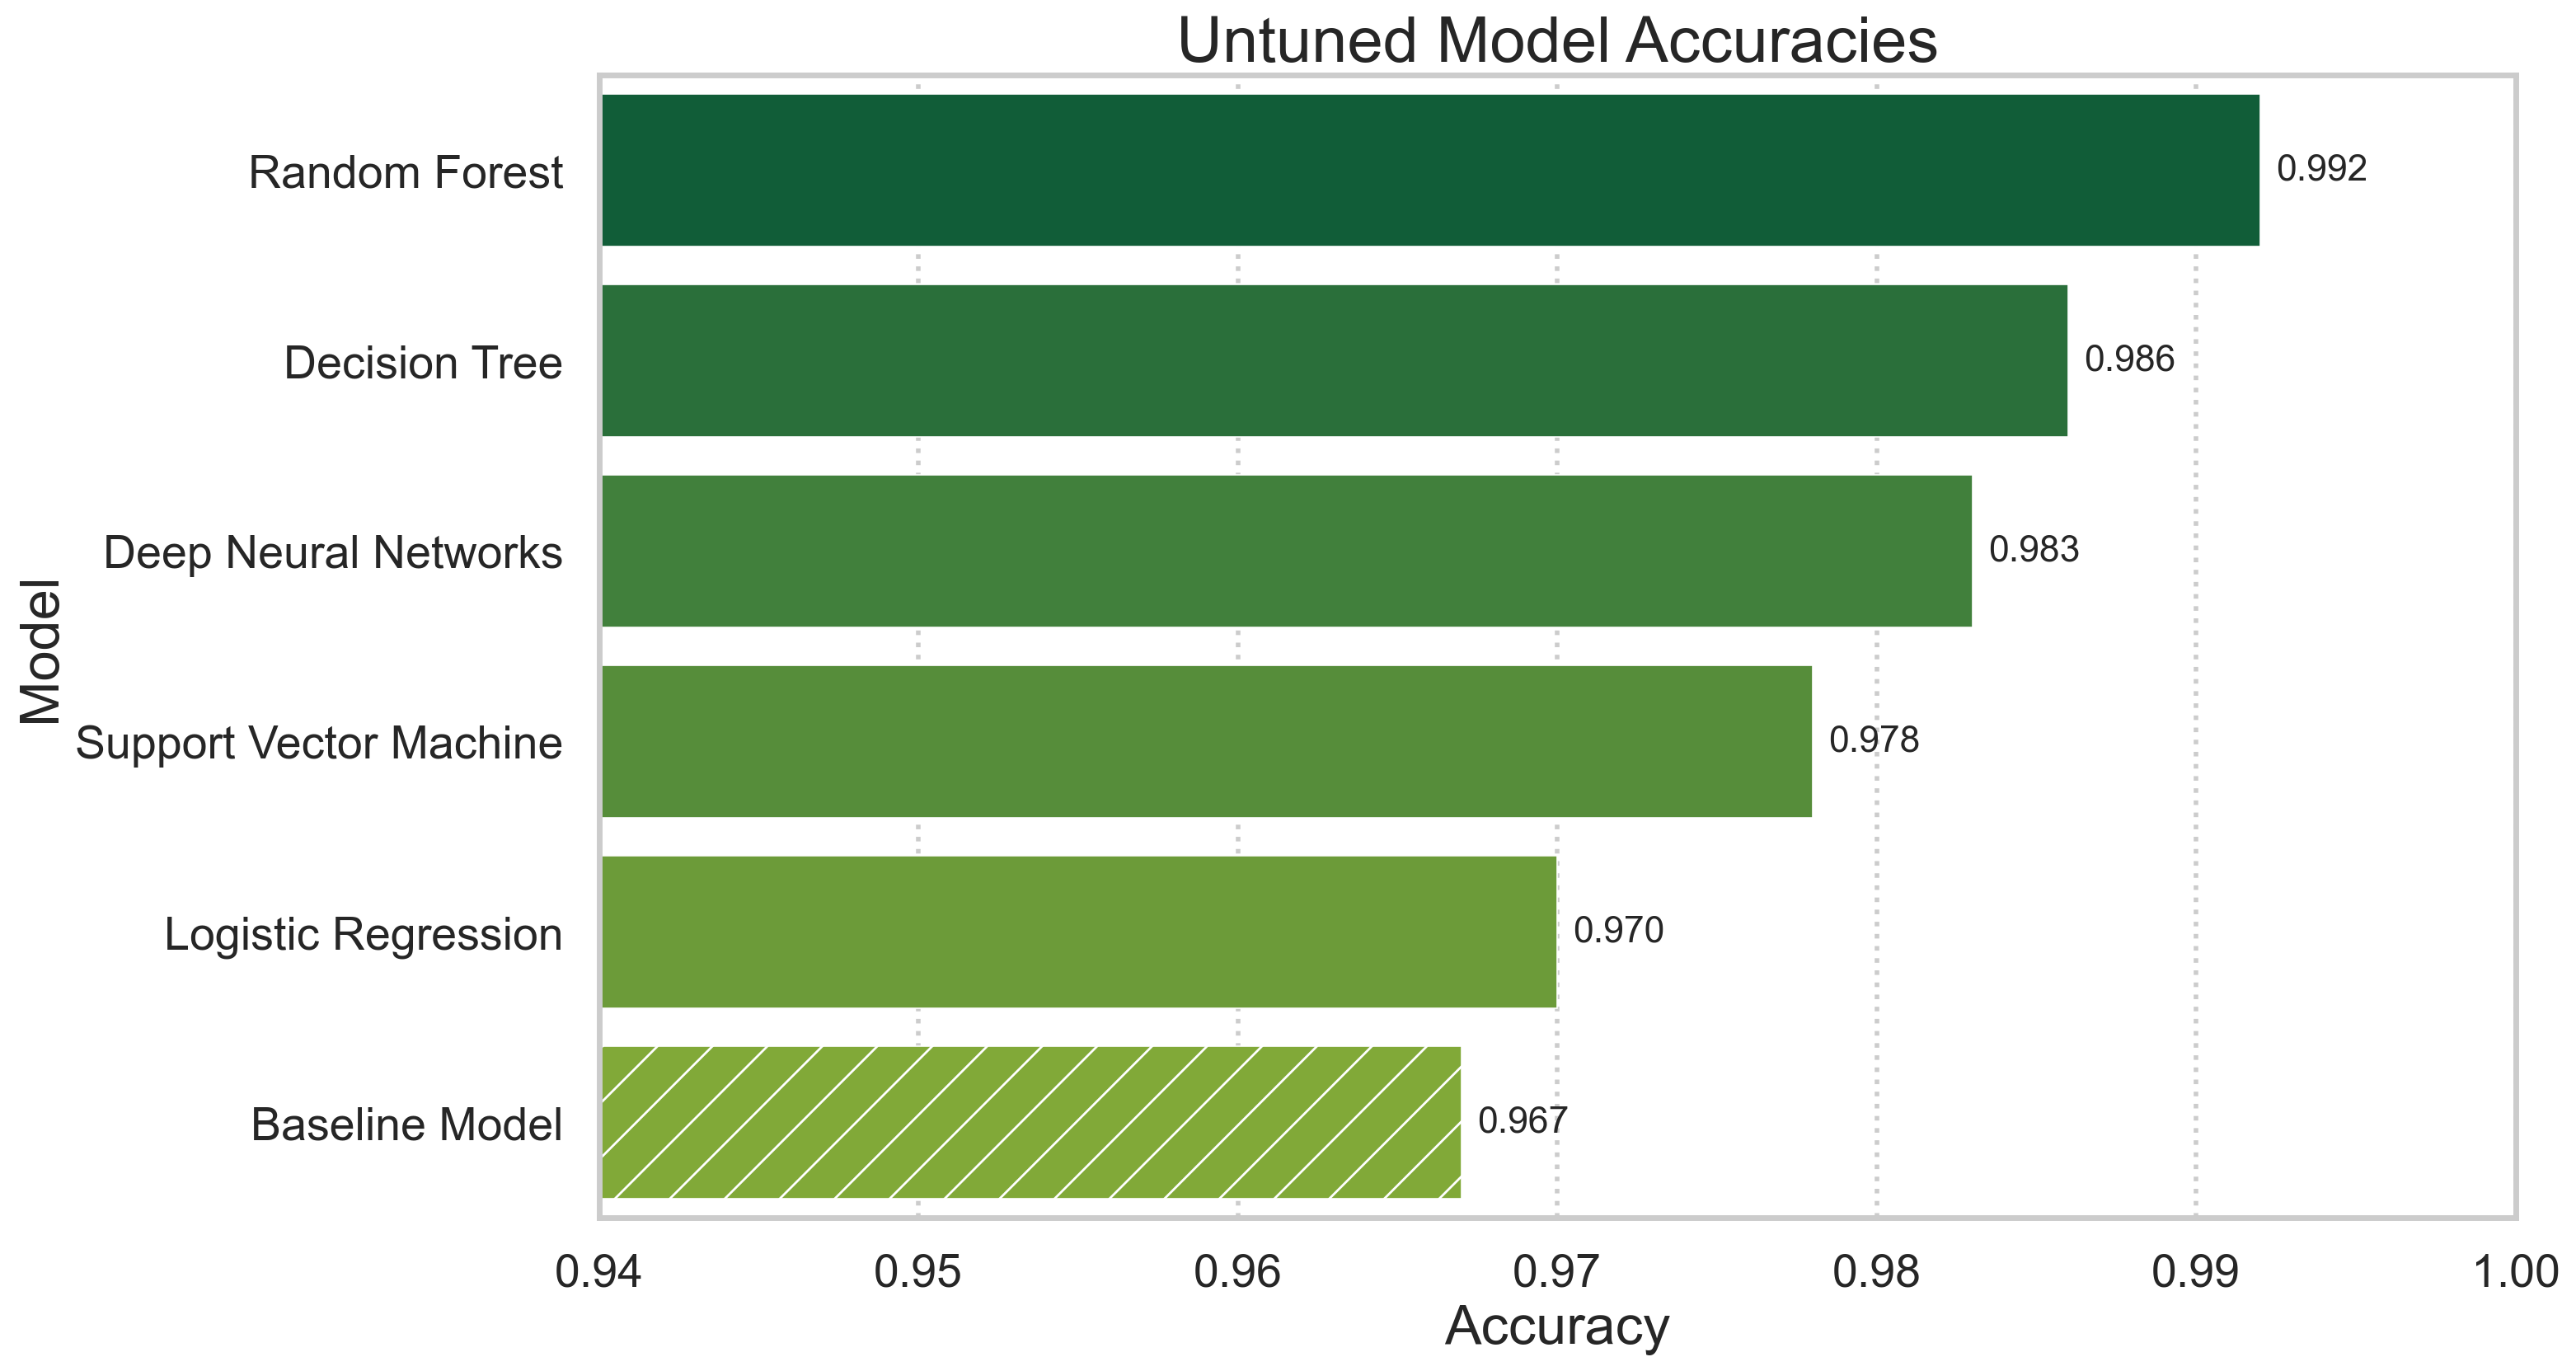

In [221]:
plt.figure(figsize=(15,9))
ax = sns.barplot(data=accuracy_df, x='accuracy', y='model', orient='h', hue='model', palette=sns.color_palette('blend:#046A38,#86BC25'))
baseline_model = ax.patches[-1]
baseline_model.set_hatch('/')
for container in ax.containers:
    ax.bar_label(container, padding=7, fontsize=16, fmt='%.3f')
plt.title('Untuned Model Accuracies', fontsize=28)
plt.xlabel('Accuracy', fontsize=24)
plt.ylabel('Model', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0.94, 1)
plt.savefig('images/untuned_model_accuracy_smooth_gradient.svg', format='svg', bbox_inches='tight')

#### Tuned Models

In [222]:
# save tuned accuracy into a dataframe
rounded_accuracy = [round(x, 3) for x in [accuracy_ga_rf, accuracy_rs_rf, accuracy_rf,
                                          accuracy_ga_tree, accuracy_rs_tree, accuracy_tree,
                                          accuracy_ga_nn, accuracy_rs_nn, accuracy_nn]]
tuned_accuracy_df = pd.DataFrame({'model': ['Random Forest', 'Random Forest', 'Random Forest',
                                            'Decision Tree', 'Decision Tree', 'Decision Tree',
                                            'Deep Neural Networks', 'Deep Neural Networks', 'Deep Neural Networks'],
                                  'accuracy': rounded_accuracy,
                                  'Tuning': ['Genetic Algorithm Search', 'Random Search', 'No Search',
                                             'Genetic Algorithm Search', 'Random Search', 'No Search',
                                             'Genetic Algorithm Search', 'Random Search', 'No Search',]
                                 })

C:\Users\hzuo\AppData\Local\Temp\ipykernel_13348\900890697.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.


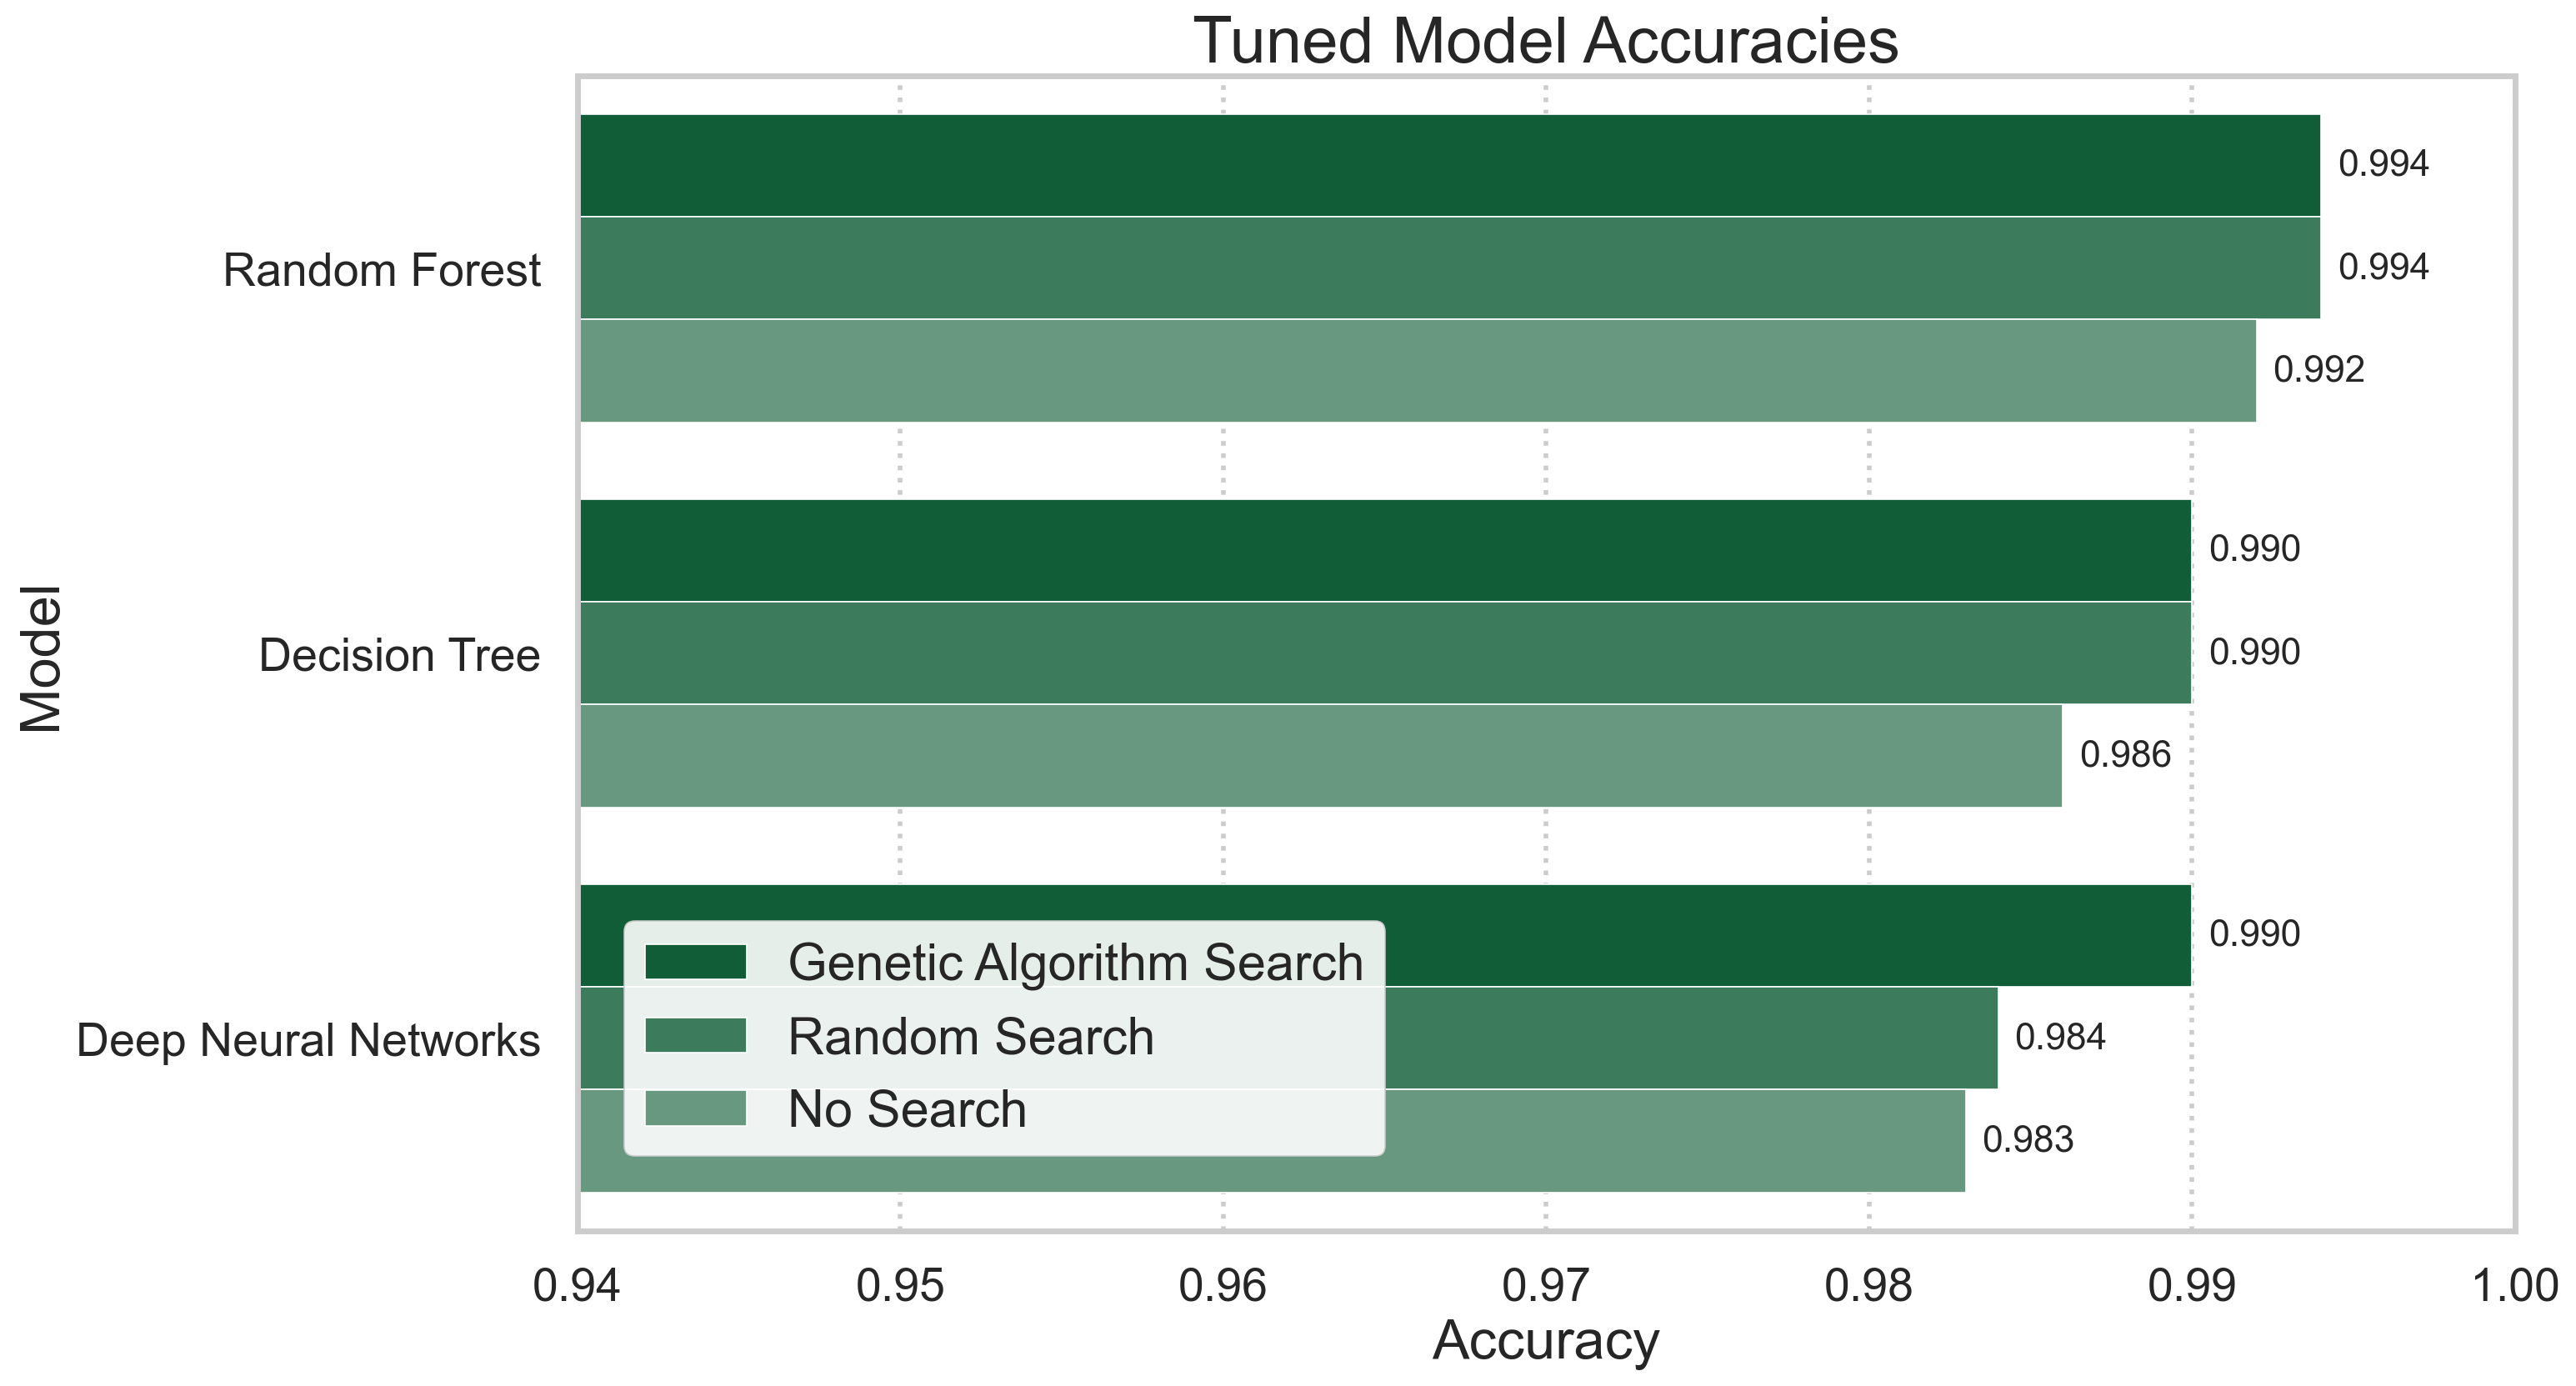

In [223]:
plt.figure(figsize=(15,9))
ax = sns.barplot(data=tuned_accuracy_df, x='accuracy', y='model', orient='h', hue='Tuning', errorbar=None,
                 palette=sns.light_palette("#046A38", reverse=True))#sns.color_palette('blend:#046A38,#86BC25')) #sns.light_palette("#046A38", reverse=True)
for container in ax.containers:
    ax.bar_label(container, padding=7, fontsize=16, fmt='%.3f')
plt.title('Tuned Model Accuracies', fontsize=28)
plt.xlabel('Accuracy', fontsize=24)
plt.ylabel('Model', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0.94, 1)
plt.legend(loc='best', bbox_to_anchor=(0, 0, 0.43, 0.29), framealpha=0.9)
plt.savefig('images/tuned_model_accuracy.svg', format='svg', bbox_inches='tight')

### Confusion matrix

In [237]:
# reset the styles
sns.set_style('white')
sns.set_context('talk')

In [238]:
confusion_matrix_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#FFFFFF", "#046A38"])

#### Tuned Models

##### complete decision tree confusion matrix

Text(0.5, 1.0, 'Decision Tree')

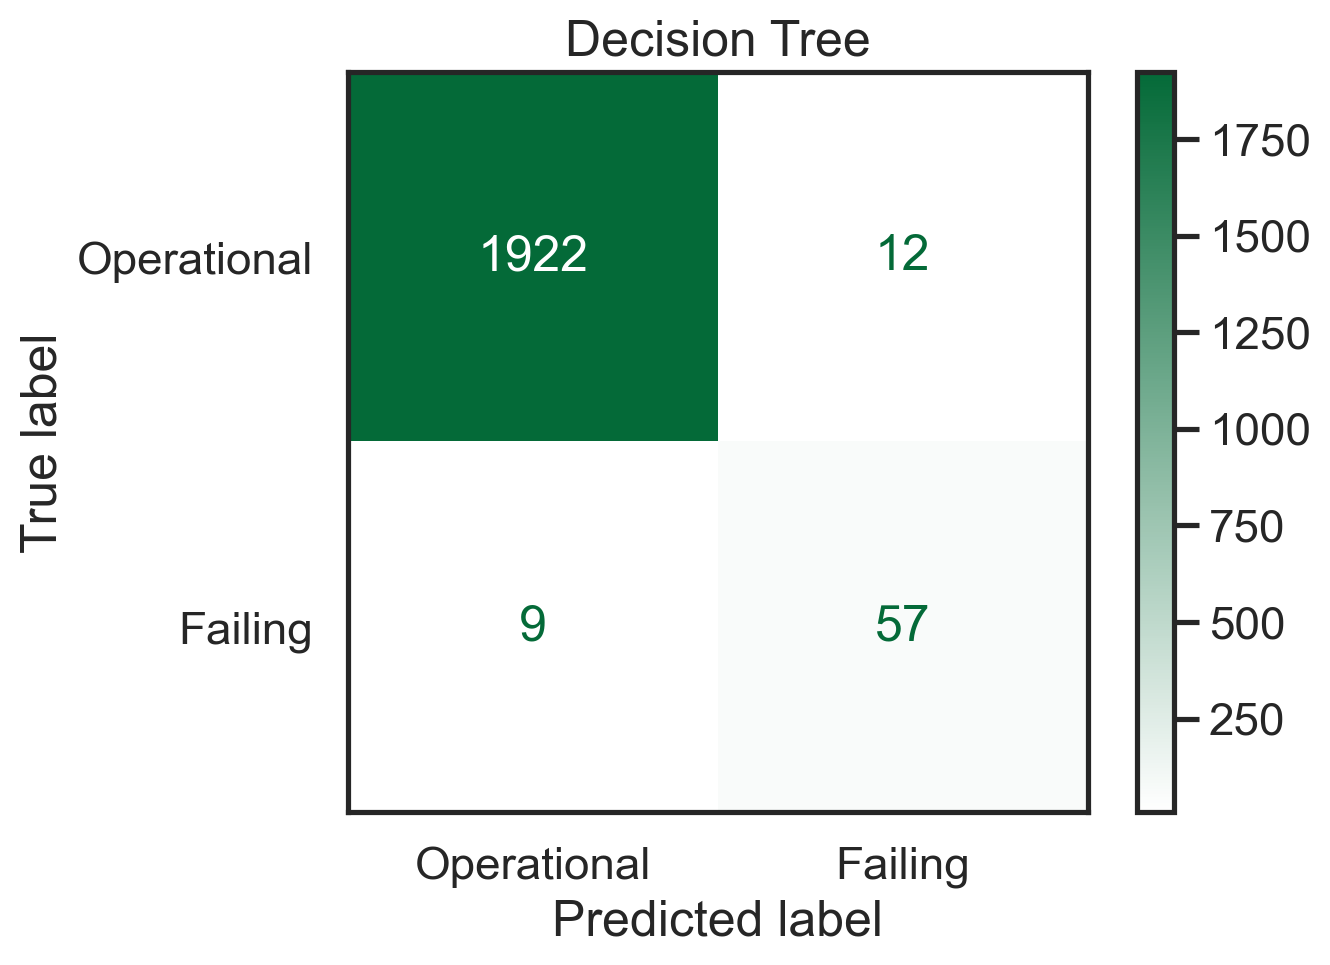

In [244]:
disp = ConfusionMatrixDisplay.from_estimator(ga_tree, X_map_test, y_map_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'])
disp.ax_.set_title("Decision Tree")

##### truncated decision tree matrix for presentation

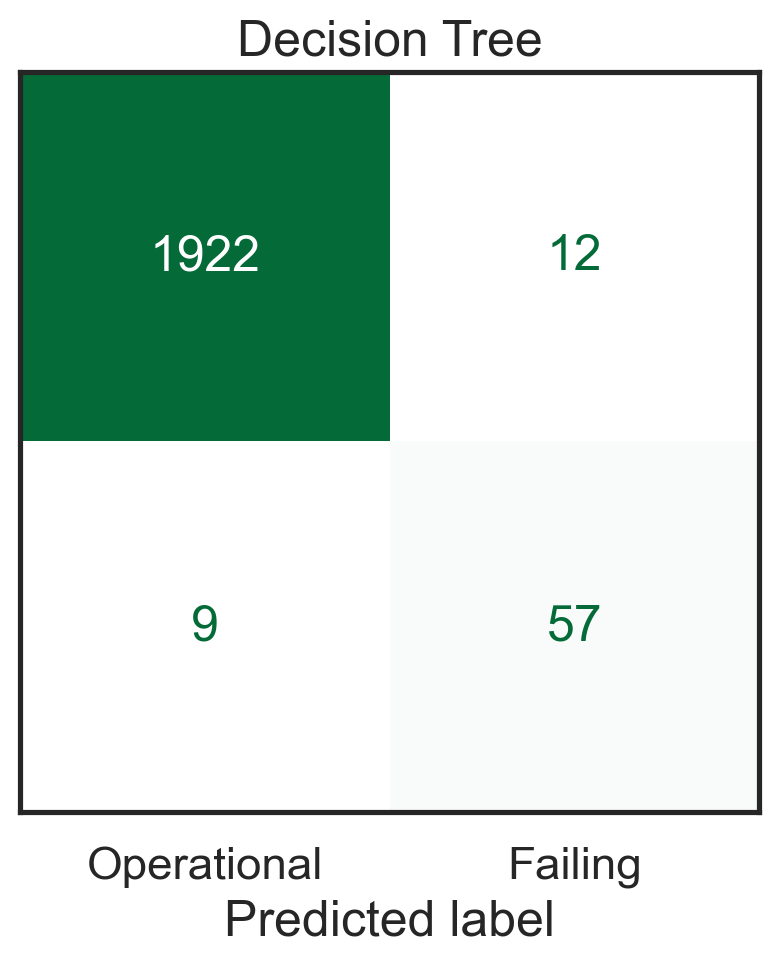

In [243]:
disp = ConfusionMatrixDisplay.from_estimator(ga_tree, X_map_test, y_map_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'], colorbar=False)
disp.ax_.get_yaxis().set_visible(False)
disp.ax_.set_title("Decision Tree")
plt.savefig('images/tuned_decision_tree_confusion_matrix.svg', format='svg', bbox_inches='tight')

##### complete deep neural networks confusion matrix

Text(0.5, 1.0, 'Deep Neural Networks')

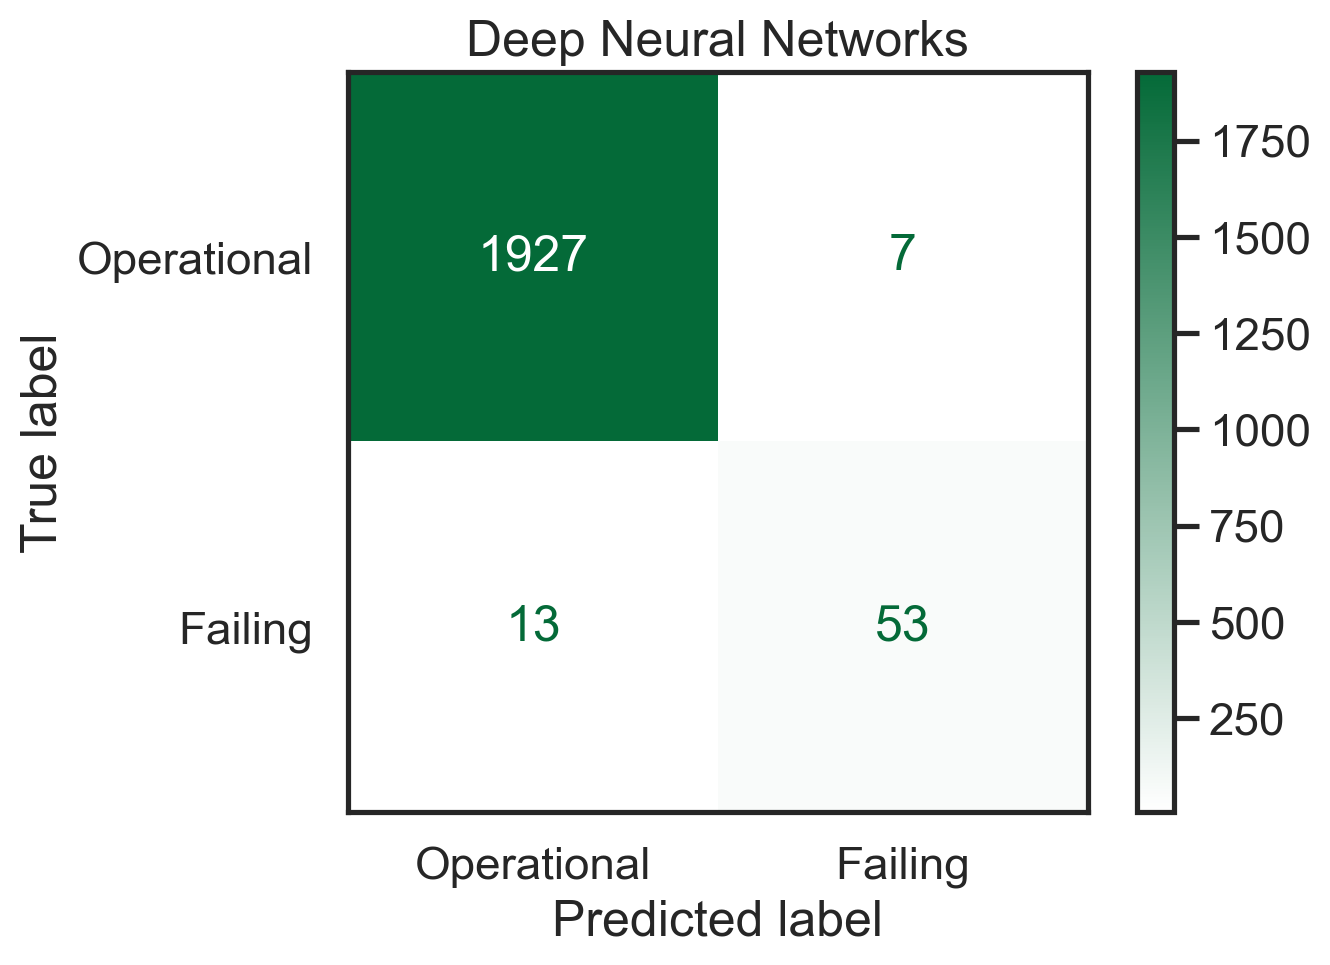

In [245]:
disp = ConfusionMatrixDisplay.from_estimator(ga_nn, X_dummy_test, y_dummy_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'], colorbar=True)
disp.ax_.set_title("Deep Neural Networks")

##### truncated deep neural networks matrix for presentation

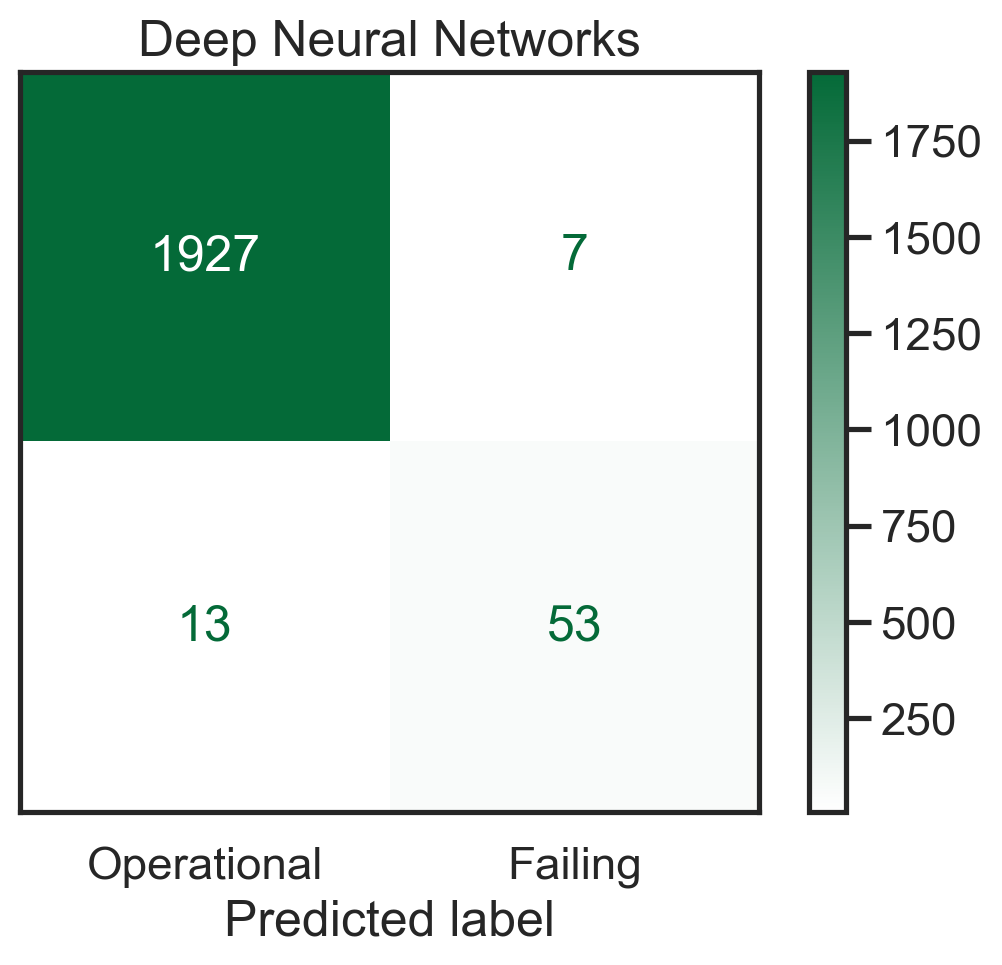

In [246]:
disp = ConfusionMatrixDisplay.from_estimator(ga_nn, X_dummy_test, y_dummy_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'], colorbar=True)
disp.ax_.get_yaxis().set_visible(False)
disp.ax_.set_title("Deep Neural Networks")
plt.savefig('images/tuned_neural_network_confusion_matrix.svg', format='svg', bbox_inches='tight')

##### complete random forest confusion matrix

Text(0.5, 1.0, 'Random Forest')

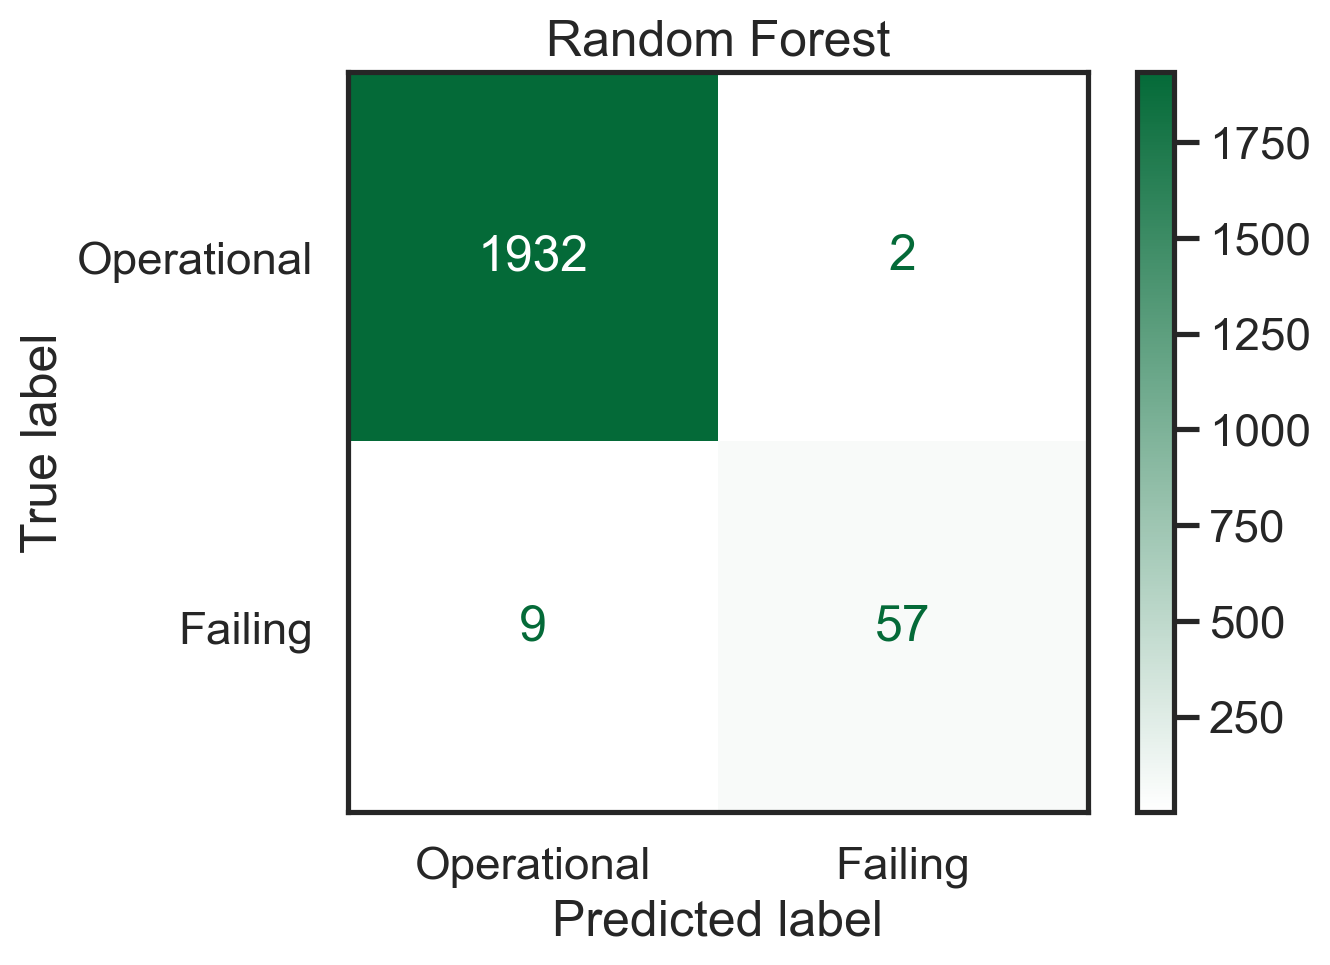

In [248]:
disp = ConfusionMatrixDisplay.from_estimator(rsearch_rf, X_map_test, y_map_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'], colorbar=True)
disp.ax_.set_title("Random Forest")

##### truncated random forest matrix for presentation

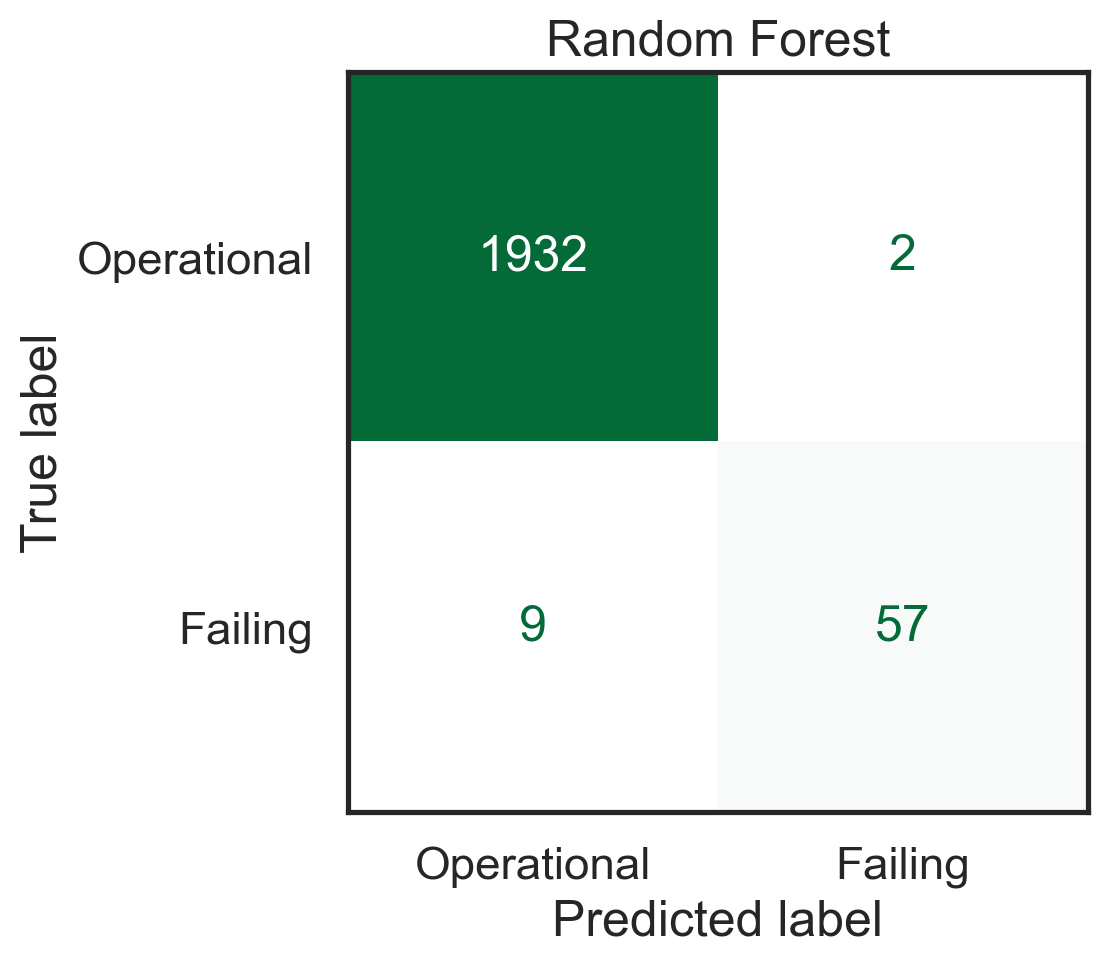

In [249]:
disp = ConfusionMatrixDisplay.from_estimator(rsearch_rf, X_map_test, y_map_test, cmap=confusion_matrix_cmap,
                                             display_labels=['Operational', 'Failing'], colorbar=False)
disp.ax_.set_title("Random Forest")
plt.savefig('images/tuned_random_forest_confusion_matrix.svg', format='svg', bbox_inches='tight')

### Precision, recall, and f1-score

#### Tuned models

In [231]:
print(f'{"Decision Tree":-^54}')
print(classification_report(y_map_test, ga_tree.predict(X_map_test)))

--------------------Decision Tree---------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1934
           1       0.83      0.86      0.84        66

    accuracy                           0.99      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.99      0.99      0.99      2000



In [233]:
print(f'{"Deep Neural Networks":-^54}')
print(classification_report(y_dummy_test, ga_nn.predict(X_dummy_test)))

-----------------Deep Neural Networks-----------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1934
           1       0.88      0.80      0.84        66

    accuracy                           0.99      2000
   macro avg       0.94      0.90      0.92      2000
weighted avg       0.99      0.99      0.99      2000



In [235]:
print(f'{"Random Forest":-^54}')
print(classification_report(y_map_test, rsearch_rf.predict(X_map_test)))

--------------------Random Forest---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1934
           1       0.97      0.86      0.91        66

    accuracy                           0.99      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.99      0.99      0.99      2000



## Conclusion and Final Model

*Recommendation:* We recommend the **random forest** model for predicting machine failure based on accuracy, precision, and recall.

*Metrics:* Accuracy measures how often a model's predictions are correct, so it serves as a good baseline metric to evaluate different models. However, accuracy does not account for imbalanced data, which can inflate a non-predictive model's accuracy. Thus, we look at two additional measures.

Precision measures how often a model's positive predictions are correct. In other words, when the model predicts machine failure, how often is it right?

Recall looks at what fraction of the true positives did the model catch. In this case, out of all of the machine failures, how many did the model predict would fail?  

Precision and recall are invaluable metrics for imbalanced datasets because they are not as sensitive to imbalance as accuracy is.

The random forest model performed the best out of all the models on the holdout dataset achieving a **99.4% accuracy, 97% precision, and 86% recall.**

*Implications:* With a fine-tuned random forest that can predict machine failures, manufacturers can avoid down time caused by malfunctioning machines and keep production running. For stakeholders, this translates into more throughput and less time wasted on tricky, just-in-time logistics. In conjunction with other systems, this model can increase production and reduce cost.